# Kuramoto-Sivashinsky (KS) equation: single parameter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
from plots import contour_plot

Ntraj_to_simulate = 100
Ntime_for_nn = 200

## Generation of the data

Solving in $[0,L]$ with $L=2\pi$ for $u_0 = \cos(\omega \cdot 2 \pi\,x/L)\cdot (1+\sin(\omega \cdot 2 \pi\,x/L))$

In [2]:
N = 2**11
L = 2 * np.pi * 16

tmax = 100
dt = 1e-2
saved_steps = Ntime_for_nn

x = L * np.linspace(0, 1, N, endpoint=False)

For different values of viscosity $\nu$, we generate the data.

In [3]:
from ks import renshaw
from tqdm import tqdm
from scipy.stats import qmc

Ns = Ntraj_to_simulate

solve_KS = True

if solve_KS:

    # Random Sampling with Latin Hypercube 
    param_bounds = [[0.5, 1.0], [1.5, 1.+1e-12]] # [lower bounder, upper bound] 0 = nu, 1 = omega
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=Ntraj_to_simulate)
    scaled_sample = qmc.scale(sample, param_bounds[0], param_bounds[1])
    nu_samples, omega_samples = scaled_sample[:, 0], scaled_sample[:, 1]

    bar = tqdm(range(Ntraj_to_simulate), 'Solving parametric KS equation')
    snapshots_data = list()
    params = list()

    for ii in range(Ntraj_to_simulate):
        
        nu = nu_samples[ii]
        omega = omega_samples[ii]
        
        u0 = lambda x: np.cos(omega * 2 * np.pi * x / L) * (1 + np.sin(omega * 2 * np.pi * x / L))

        snapshots_data.append(renshaw(x, u0, tmax = tmax, N = N, h = dt, nu = nu, saved_steps=saved_steps))
        params.append(np.array([nu, omega]))
            
        bar.update(1)
            
    params = np.asarray(params)

    pickle.dump([snapshots_data, params], open('snapshots_data.pkl', 'wb'))
else:
    snapshots_data, params = pickle.load(open('snapshots_data.pkl', 'rb'))

Solving parametric KS equation: 100%|██████████| 100/100 [03:51<00:00,  2.25s/it]

### Comparison plots and saving

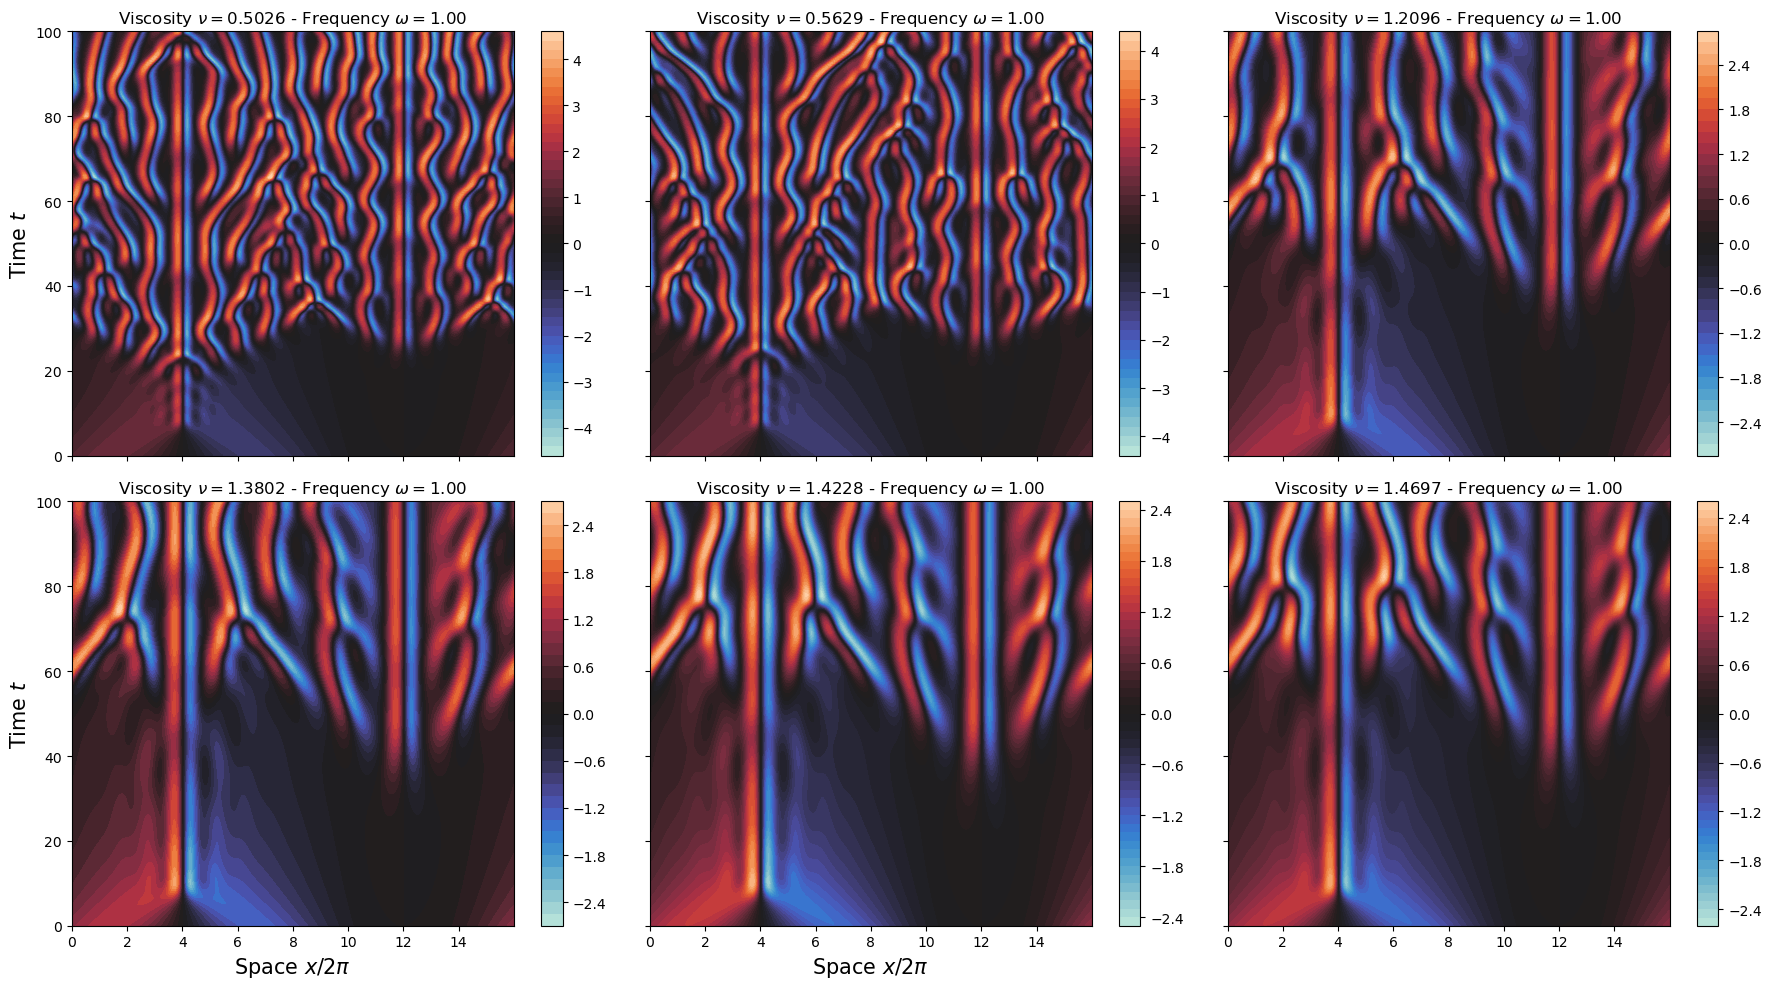

In [4]:
import seaborn as sns

nrows = 2
ncols = 3

param_to_plot = np.random.choice(len(snapshots_data), nrows * ncols, replace=False)
argsort = np.argsort(params[param_to_plot, 0])
param_to_plot = param_to_plot[argsort]

fig, axs = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize=(6 * ncols, 5*nrows))

axs = axs.flatten()

levels = 50

for ii, param in enumerate(param_to_plot):
    contour_plot(axs[ii], *snapshots_data[param], 
                 title=r'Viscosity $\nu={:.4f}$'.format(params[param,0])+r' - Frequency $\omega={:.2f}$'.format(params[param,1]), 
                 levels=levels, cmap=sns.color_palette('icefire', as_cmap=True))

axs = axs.reshape(nrows, ncols)
for jj in range(nrows):
    axs[jj, 0].set_ylabel(r'Time $t$', fontsize=15)

axs[-1,0].set_xlabel(r'Space $x/2\pi$', fontsize=15)
axs[-1,1].set_xlabel(r'Space $x/2\pi$', fontsize=15)

plt.tight_layout()

Let us store the snapshots

In [5]:
snaps = dict()
domain = x
snaps['t'] = snapshots_data[0][1]
snaps['params'] = params
snaps['snapshots'] = {'u': [snap[2].T for snap in snapshots_data]}

N_params = params.shape[1]
Nh = len(x)
Nt = len(snaps['t'])

assert snaps['snapshots']['u'][0].shape == (Nh, Nt)

Split into train, test and validation for the parameter

In [6]:
np.random.seed(5)

ntrajectories = len(snaps['params'])
ntrain = int(0.85 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

dataset = dict()
dataset['u'] = {
    'train': np.asarray([snaps['snapshots']['u'][idx].T for idx in idx_train]),
    'valid': np.asarray([snaps['snapshots']['u'][idx].T for idx in idx_valid]),
    'test': np.asarray([snaps['snapshots']['u'][idx].T  for idx in idx_test]),
}

mu = np.zeros((ntrajectories, Nt, N_params))
for idx in range(ntrajectories):
    for tt in range(Nt):
        mu[idx, tt] = snaps['params'][idx]

dataset['params'] = {
    'train': mu[idx_train],
    'valid': mu[idx_valid],
    'test':  mu[idx_test],
}

Let us plot the parameter space

Text(0, 0.5, '')

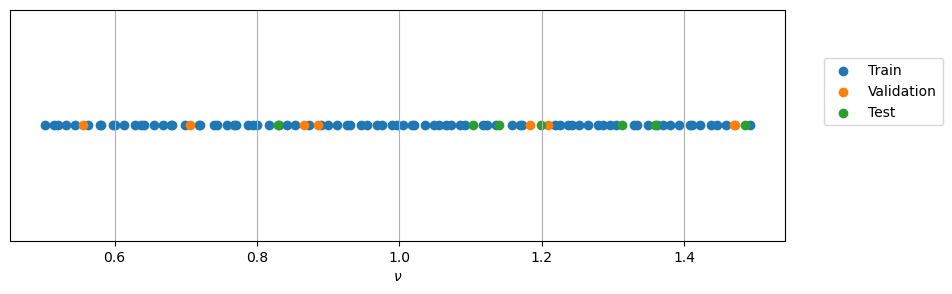

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))

axs.scatter(dataset['params']['train'][:, 0, 0], dataset['params']['train'][:, 0, 1], label='Train')
axs.scatter(dataset['params']['valid'][:, 0, 0], dataset['params']['valid'][:, 0, 1], label='Validation')
axs.scatter(dataset['params']['test'][:, 0, 0],  dataset['params']['test'][:, 0, 1], label='Test')

axs.set_xlabel(r'$\nu$')
axs.set_ylabel(r'$\omega$')
axs.legend(loc=(1.05, 0.5))   
axs.grid()

axs.set_ylim(0.9, 1.1)
axs.set_yticks([])
axs.set_ylabel('')

# axs.set_xlim(0.9, 1.1)
# axs.set_xticks([])
# axs.set_xlabel('')

## Singular Value Decomposition

In [12]:
from sklearn.utils.extmath import randomized_svd
import numpy as np
from scalers import ICStdScaler, ICMinMaxScaler

rescaling_snaps = list()
var_names = ['u']
Nmodes = []

u_total = dict()
s_total = dict()

modes_number = [35]

for field_i, field in enumerate(var_names):
    u = dataset[field]['train'].reshape(-1, Nh).T
    rescaling_snaps.append(ICMinMaxScaler(u))
    
    X = rescaling_snaps[field_i].transform(u)
    
    _Nmodes = modes_number[field_i]
    
    Nmodes.append(_Nmodes)
    
    u_svd, s_svd, v_svd = randomized_svd(X, n_components = _Nmodes, n_iter = 'auto')

    if field_i == 0:
        v_total = v_svd
    else:
        v_total = np.vstack((v_total, v_svd))
        
    s_total[field] = s_svd.flatten()
    u_total[field] = u_svd
        
Nmodes = np.asarray(Nmodes)


Let us plot the sing vals

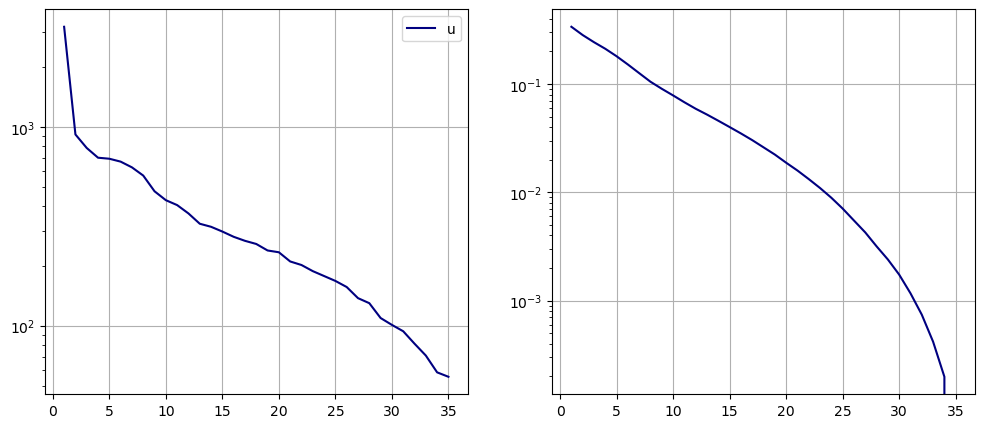

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

colors = cm.jet(np.linspace(0,1,len(var_names)))
for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, Nmodes[field_i]+1, 1)
    axs[0].semilogy(N_plot, s_total[field], color=colors[field_i], label=field)
    axs[1].semilogy(N_plot, 1-np.cumsum(s_total[field]**2) / np.sum(s_total[field]**2), color=colors[field_i], label=field)
axs[0].grid()
axs[1].grid()
axs[0].legend()

Checking the train, test and valid error

In [14]:
for field_i in range(len(var_names)):
    field = var_names[field_i]

    for key in dataset[field]:
        true_field = rescaling_snaps[field_i].transform(dataset[field][key].reshape(-1, Nh).T)

        _vh = np.linalg.multi_dot([np.linalg.inv(np.diag(s_total[field])), u_total[field].T, true_field])
        rec = np.linalg.multi_dot([u_total[field], np.diag(s_total[field]), _vh])

        errors = np.linalg.norm(rec - true_field, axis = 0) / np.linalg.norm(true_field, axis=0)

        print(field + ' - '+ key)
        print('   max = {:.3e}'.format(np.max(errors)) +' and ave {:.3e}'.format(np.mean(errors)))

u - train
   max = 1.105e-01 and ave 1.366e-02
u - valid
   max = 7.219e-02 and ave 1.290e-02
u - test
   max = 2.014e-02 and ave 6.914e-03


Let us store the POD coefficients

In [15]:
_v_POD = {
    'train': np.linalg.multi_dot([np.linalg.inv(np.diag(s_total['u'])),  u_total['u'].T, rescaling_snaps[0].transform(dataset['u']['train'].reshape(-1, Nh).T)]),
    'valid': np.linalg.multi_dot([np.linalg.inv(np.diag(s_total['u'])),  u_total['u'].T, rescaling_snaps[0].transform(dataset['u']['valid'].reshape(-1, Nh).T)]),
    'test':  np.linalg.multi_dot([np.linalg.inv(np.diag(s_total['u'])),  u_total['u'].T, rescaling_snaps[0].transform(dataset['u']['test'].reshape( -1, Nh).T)]),
}

Let us reshape the coefficients

In [16]:
v_POD = {
    'train': _v_POD['train'].T.reshape(ntrain, Nt, Nmodes[0]),
    'valid': _v_POD['valid'].T.reshape(nvalid, Nt, Nmodes[0]),
    'test':  _v_POD['test'].T.reshape(  ntest, Nt, Nmodes[0])
}

Let us make a contour plot on the test set

[0.82949108 1.        ]


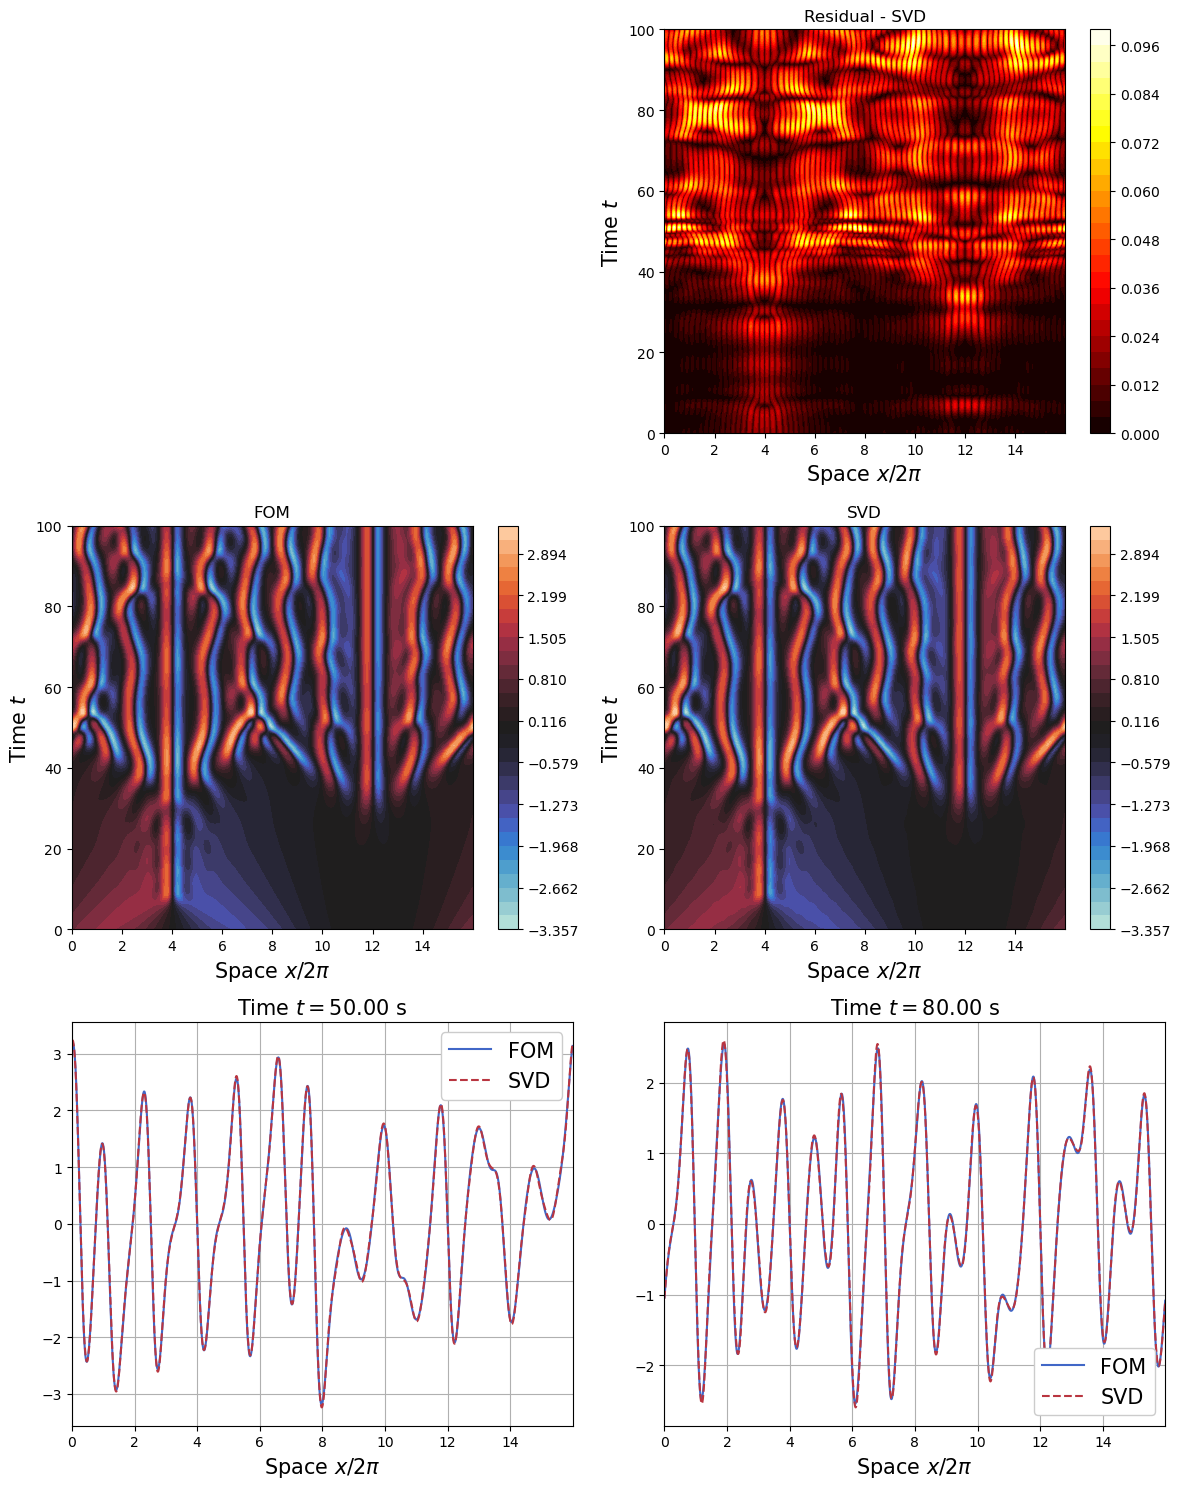

In [34]:
from plots import plot_FOM_vs_Recon

param_to_plot = 5
print(dataset['params']['test'][param_to_plot, 0])

recons = {'SVD': rescaling_snaps[field_i].inverse_transform(np.linalg.multi_dot([u_total[field], 
                                                            np.diag(s_total[field]), 
                                                            v_POD['test'][param_to_plot, :].T]))}
plot_FOM_vs_Recon(domain, snaps['t'], dataset[field]['test'][param_to_plot].T, recons, 
                  time_idx = [0.5, 0.8])

## Compute Measures

In [35]:
measured_field = 0

from tqdm import tqdm
num_sensors = 3
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

n_configurations = 3
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)
sensors = list()

snap_measurements = list()

np.random.seed(109) # set seed for reproducibility
for kk in tqdm(range(n_configurations), 'Creating sensors'):

    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(domain, size=num_sensors, replace=False), dtype=int)

    snap_measurements.append({
        key: dataset[var_names[measured_field]][key][:, :, idx_sensor_locations[:,kk]]
        for key in list(dataset[var_names[measured_field]].keys())
    })

Creating sensors: 100%|██████████| 3/3 [00:00<00:00, 604.48it/s]


Let us add uncorrelated Gaussian noise to the measures

In [36]:
noise_value = 0.075
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append({
        key: snap_measurements[kk][key] + np.random.normal(scale=noise_value, size=snap_measurements[kk][key].shape)
        for key in list(snap_measurements[kk].keys())
    })

Plotting some measures

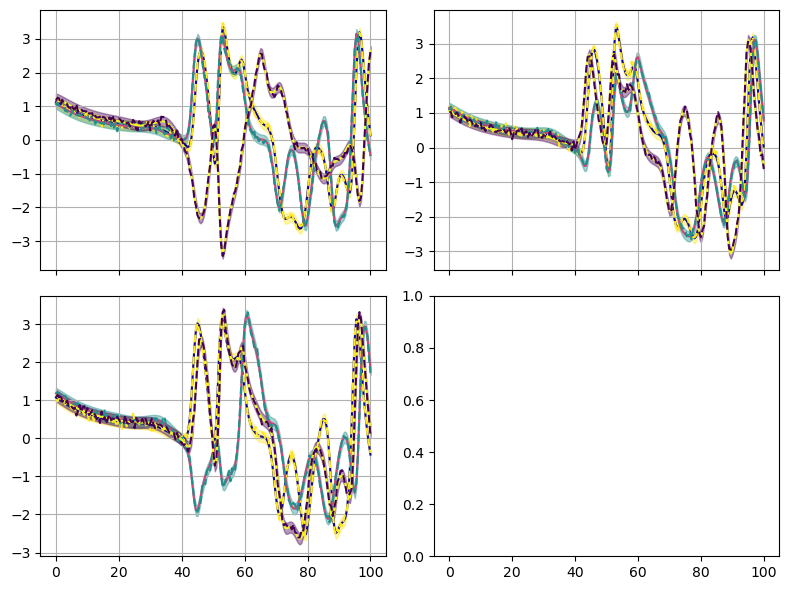

In [37]:
ncols = 2
nrows = 2
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize= (4 * ncols, 3 * nrows))
axs = axs.flatten()

param_to_plot = 0

colors = cm.plasma(np.linspace(0,1,num_sensors))
colors_gt = cm.viridis_r(np.linspace(0,1,num_sensors))
for kk in range(n_configurations):
    for jj in range(num_sensors):
        axs[kk].plot(snaps['t'], snap_measurements[kk]['train'][param_to_plot, :, jj], color=colors[jj], label='True')
        axs[kk].plot(snaps['t'], Xsensor[kk]['train'][param_to_plot, :, jj],  '--', color=colors_gt[jj])
        axs[kk].fill_between(snaps['t'], snap_measurements[kk]['train'][param_to_plot, :, jj] - 1.96 * noise_value,
                             snap_measurements[kk]['train'][param_to_plot, :, jj] +  1.96 * noise_value, color=colors_gt[jj], alpha=0.4)
    axs[kk].grid()
    
plt.tight_layout()

Let us rescale the measures

In [38]:
from sklearn.preprocessing import MinMaxScaler

rescaled_Xsensor = list()
sens_scaler = list()
for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk]['train'].reshape(-1, num_sensors))

    rescaled_Xsensor.append({
        key: sens_scaler[kk].transform(Xsensor[kk][key].reshape(-1, num_sensors)).reshape(Xsensor[kk][key].shape)
        for key in list(Xsensor[kk].keys())
    })

print('Rescaled Sensors Shape')
print(rescaled_Xsensor[0]['train'].shape)
print(rescaled_Xsensor[0]['test'].shape)
print(rescaled_Xsensor[0]['valid'].shape)

Rescaled Sensors Shape
(85, 201, 3)
(7, 201, 3)
(8, 201, 3)


## Padding
In this section, the data are prepared to be fed into the SHRED architecture.

At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [39]:
assert sum(Nmodes) == v_POD['train'].shape[2]

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(v_POD['train'].reshape(-1, sum(Nmodes)))

rescaled_v_POD = {
    key: vpod_scaler.transform(v_POD[key].reshape(-1, sum(Nmodes))).reshape(v_POD[key].shape)
    for key in list(v_POD.keys())
}

Let us rescale the parameters data

In [40]:
param_scaler = MinMaxScaler()
param_scaler.fit(dataset['params']['train'].reshape(-1, N_params))

rescaled_parameters = {
    key: param_scaler.transform(dataset['params'][key].reshape(-1, N_params)).reshape(dataset['params'][key].shape)
    for key in list(dataset['params'].keys())
}

print('Params Shape')
print(rescaled_parameters['train'].shape)
print(rescaled_parameters['test'].shape)
print(rescaled_parameters['valid'].shape)

print('POD Coeff Shape')
print(rescaled_v_POD['train'].shape)
print(rescaled_v_POD['test'].shape)
print(rescaled_v_POD['valid'].shape)

Params Shape
(85, 201, 2)
(7, 201, 2)
(8, 201, 2)
POD Coeff Shape
(85, 201, 35)
(7, 201, 35)
(8, 201, 35)


Let us use the Padding to prepare the data for the SHRED architecture

In [41]:
import sys

sys.path.append('../')

from utils.processdata import Padding, TimeSeriesDataset
import torch

lags = 20

train_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['train']), lags) for kk in range(n_configurations)]
valid_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['valid']), lags) for kk in range(n_configurations)]
test_data_in  = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['test']), lags)  for kk in range(n_configurations)]

# Output composed by POD coefficients and Parameters 
train_data_out = Padding(torch.from_numpy(rescaled_v_POD['train']), 1).squeeze(1) 
valid_data_out = Padding(torch.from_numpy(rescaled_v_POD['valid']), 1).squeeze(1) 
test_data_out  = Padding(torch.from_numpy(rescaled_v_POD['test']), 1).squeeze(1) 
output_size = sum(Nmodes)  

train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk], test_data_out)   for kk in range(n_configurations)]

## SHRED

Let us train the SHRED models for each configuration

In [42]:
from utils.models import SHRED, fit

shred = list()

for kk in range(n_configurations):

    print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

    shred.append(SHRED( num_sensors, output_size, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1))
    fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                            batch_size = 64, epochs = 3000, lr = 1e-4, verbose = True, patience = 50)

    print(' ')

Training SHRED - configuration 1/3
Training done: Training loss = 3.31% 	 Validation loss = 7.73%       
 
Training SHRED - configuration 2/3
Training done: Training loss = 3.39% 	 Validation loss = 8.04%       
 
Training SHRED - configuration 3/3
Training done: Training loss = 3.30% 	 Validation loss = 7.78%       
 


Let us check the test errors of the POD coefficients

In [63]:
from utils.processdata import num2p, mre

# Freeze SHRED weights
[_shred.freeze() for _shred in shred]

Ytest_POD_hat = np.asarray([shred[kk](test_data_in[kk]).numpy() for kk in range(n_configurations)])

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0),
    'std':  Ytest_POD_hat.std(axis=0)
}

print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_data_out,
                                                                            Ytest_POD_pred['mean'])))

Mean relative SHRED prediction error on POD coeffs: 3.77%.


Let us reshape the output of the SHRED models and the associated test data to simplify the access to the variables.

In fact, the output of the SHRED models is a 2D array with dimensions $N_p^{test}\cdot N_t \times (R+N_{params})$, given $N_p$ the number of elements in the parameter test set, $N_t$ the number of time steps, $R$ the number of total rank of the latent space and $N_{params}$ the number of parameters (only 1, since $\tau$ only has been considered).

In [64]:
idx_params = {
    'train': idx_train,
    'valid': idx_valid,
    'test':  idx_test
}

reshaped_test_out = test_data_out.cpu().detach().numpy().reshape(len(idx_params['test']), Ntime_for_nn+1, output_size)

reshaped_POD_test_out = {
    'mean': Ytest_POD_pred['mean'].reshape(len(idx_params['test']), Ntime_for_nn+1, output_size)[:, :, :sum(Nmodes)],
    'std':  Ytest_POD_pred['std'].reshape(len(idx_params['test']), Ntime_for_nn+1, output_size)[:, :, :sum(Nmodes)]
}

Let us decode the full state space

In [65]:
from tqdm import tqdm

ave_rel_errors = {
    'mean': np.zeros((len(var_names), len(idx_params['test']), Ntime_for_nn+1)),
    'std' : np.zeros((len(var_names), len(idx_params['test']), Ntime_for_nn+1))
}

for field_i in range(len(var_names)):
    field = var_names[field_i]
    idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

    for param_to_recon in tqdm(range(len(idx_params['test'])), 'Computing error for '+field):
        fom = dataset[field]['test'][param_to_recon].T

        _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape)
        _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'].shape) - vpod_scaler.data_min_

        recon     = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_recon, :, idx_to_rec]))
        std_recon = rescaling_snaps[field_i].inverse_std_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_std_v[ param_to_recon, :, idx_to_rec]))

        ave_rel_errors['mean'][field_i, param_to_recon] = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
        ave_rel_errors['std'][field_i, param_to_recon]  = np.linalg.norm(std_recon, axis=0)   / np.linalg.norm(fom, axis=0)

Computing error for u: 100%|██████████| 7/7 [00:00<00:00, 53.29it/s]


Let us plot the errors using bar plots

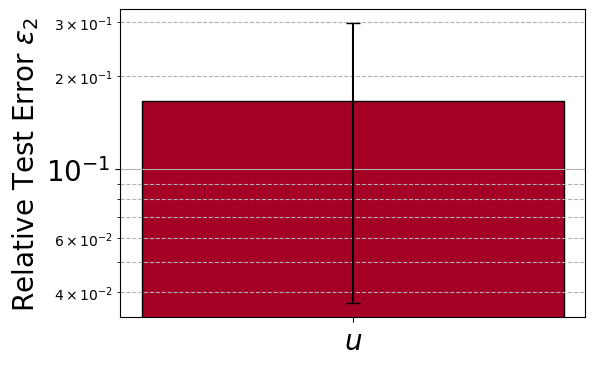

In [66]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(6,4))

colors = cm.jet(np.linspace(0,1, len(var_names)))
axs.bar(np.arange(1, len(var_names)+1, 1), ave_rel_errors['mean'].mean(axis=2).mean(axis=1), 
        yerr = ave_rel_errors['mean'].std(axis=2).mean(axis=1), capsize=5,
        color = cm.RdYlBu(np.linspace(0,1,len(var_names))),
        edgecolor='k')

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

Let us make some contour plot

[0.82949108 1.        ]


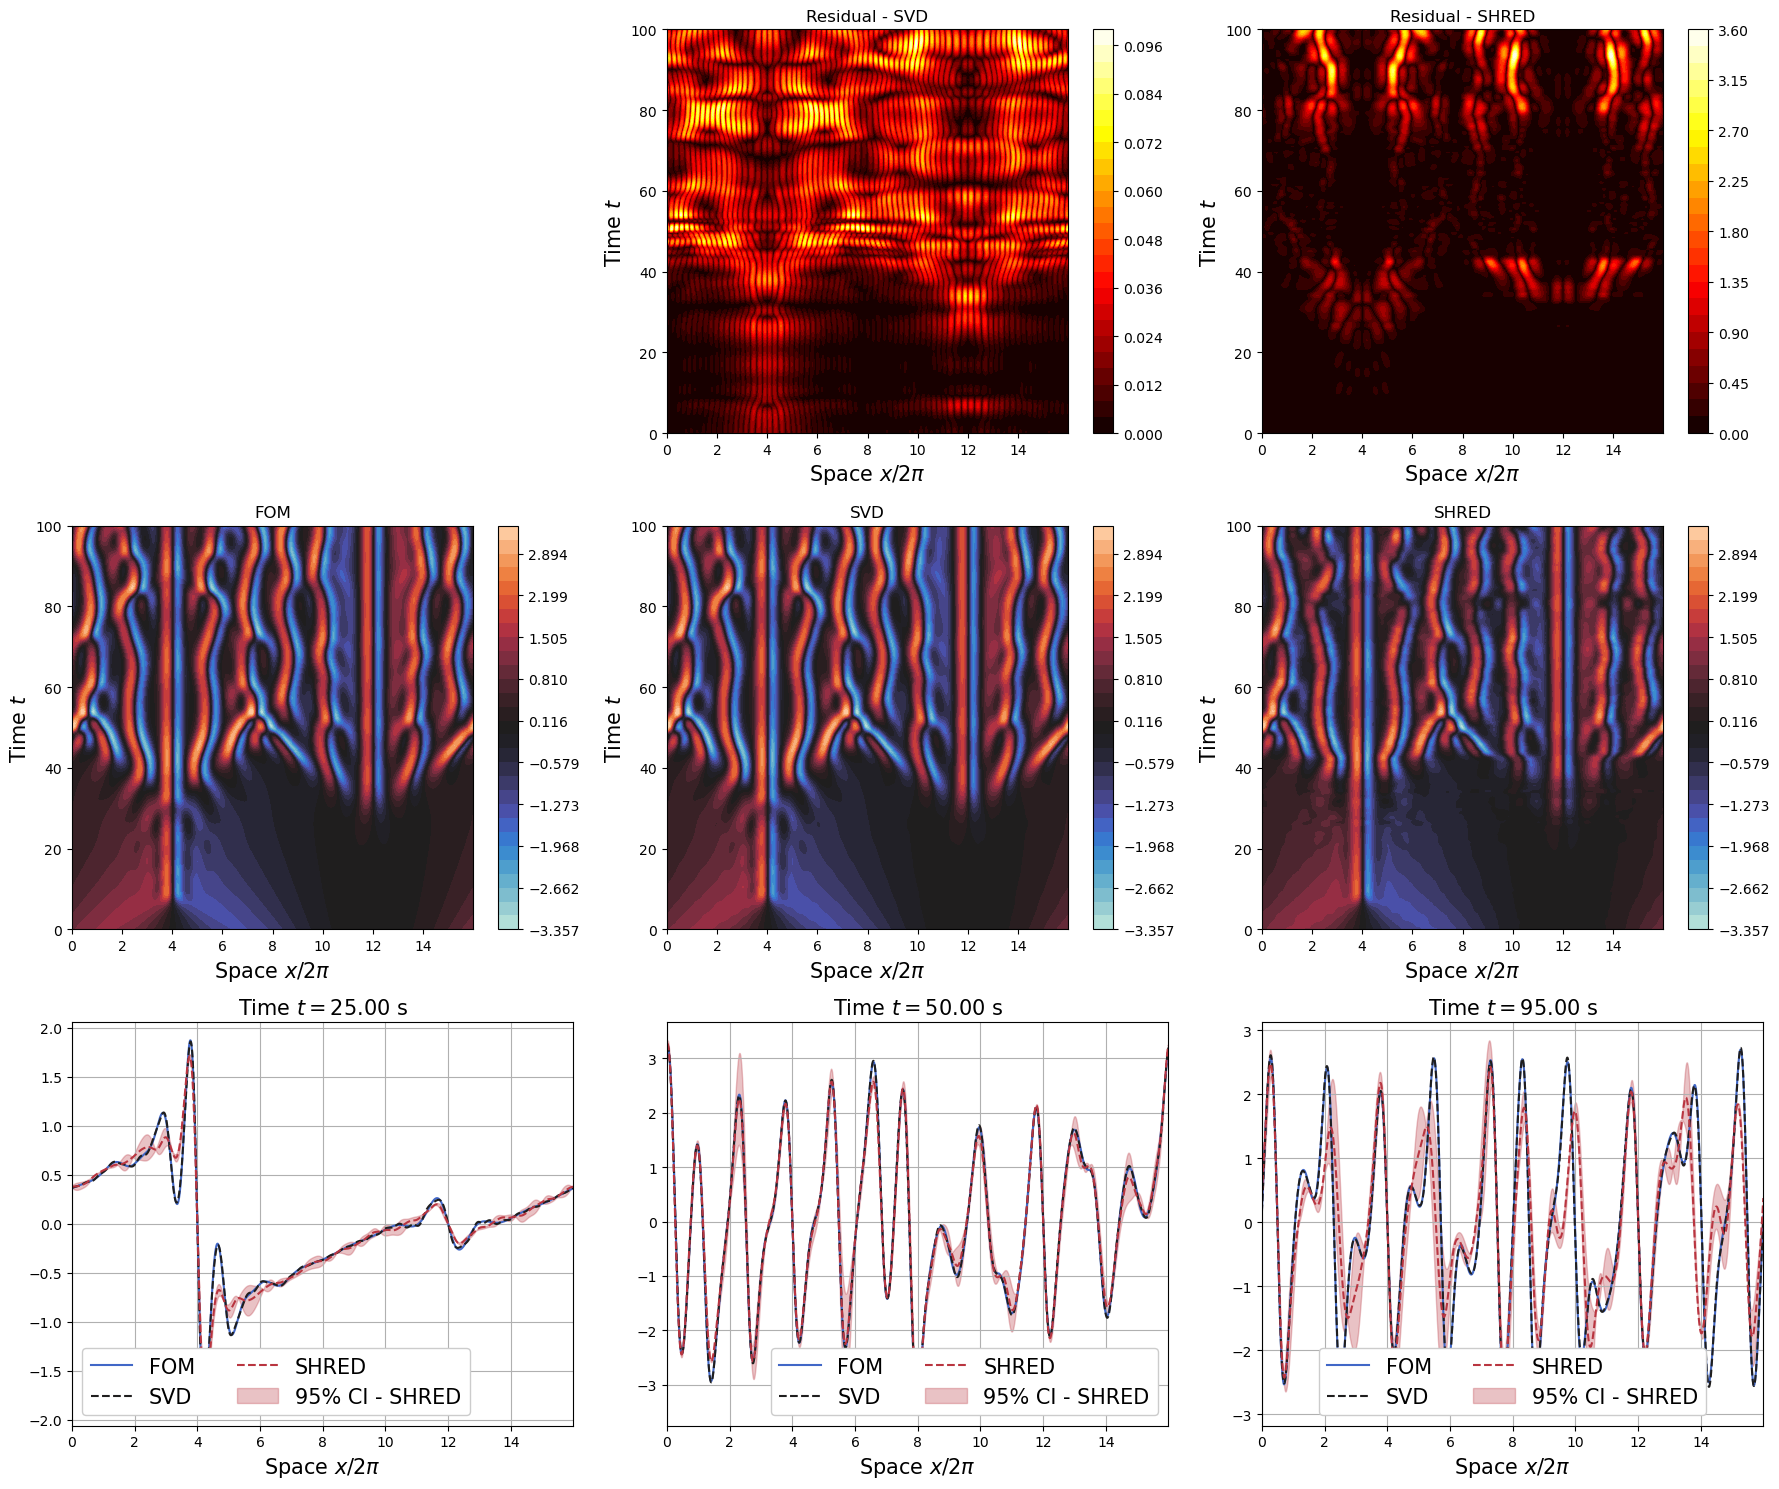

In [70]:
param_to_plot = 5
print(dataset['params']['test'][param_to_plot, 0])

fom = dataset[field]['test'][param_to_plot].T

idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

# Reconstruct the FOM with SVD
idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)
_tmp_mean_v = vpod_scaler.inverse_transform(reshaped_test_out[:, :, :sum(Nmodes)].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape)

recon_svd = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_plot, :, idx_to_rec]))

# Reconstruct the FOM with SHRED
idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)
_tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape)
_tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'].shape) - vpod_scaler.data_min_

recon_shred     = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_plot, :, idx_to_rec]))
recon_std_shred = rescaling_snaps[field_i].inverse_std_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_std_v[ param_to_plot, :, idx_to_rec]))

recons = {'SVD': recon_svd,
          'SHRED': recon_shred}

std_recons = {'SVD': None,
            'SHRED': recon_std_shred}

plot_FOM_vs_Recon(domain, snaps['t'], dataset[field]['test'][param_to_plot].T, recons,
                    std_recons = std_recons,
                    time_idx = [0.25, 0.5, 0.95])

This is the plot for the `README.md` file

In [71]:
from plots import plot_FOM_vs_SHRED

plot_FOM_vs_SHRED(domain, snaps['t'], dataset[field]['test'][param_to_plot].T, recons['SHRED'], 
                    filename = '../media/KuramotoSivashinsky', format = 'png', 
                    nlevels=100)